# SIRD model

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

<img src='https://www.researchgate.net/profile/Claudio-Struchiner-2/publication/47676805/figure/fig2/AS:343729496969224@1458962906357/SIR-model-Schematic-representation-differential-equations-and-plot-for-the-basic-SIR.png'>
<p>I chose this model instead of using the SEIR model or other models related to vaccinated cases because people in Thailand are vaccinated only 15.5% (10/08/2021). I also consider the vaccinated as Susceptible because the vaccine can't cover the infection. That's why we consider as the only a 3-state deterministic model (SIR model)</p>

In [2]:
def data_spilt(data:'gamma, beta', orders:'order for FIR filter', start:'Start date of your data') -> 'Train and Test':
    x_train = np.empty((len(data) - start - orders, orders)) # เป็นการสร้างเพื่อให้ไว้เอาข้อมูลเอามาใส่นั้นเอง
    y_train = data[start + orders:]

    for i in range(len(data) - start - orders):
        x_train[i] = data[i + start:start + orders + i]


    return x_train, y_train

In [3]:
covid_df = pd.read_excel('./data/covid19 TH new.xlsx',index_col=0)
covid_df.index = pd.to_datetime(covid_df.index)

In [4]:
covid_df.tail()

,NewConfirmed,NewRecovered,NewHospitalized,NewDeaths,Confirmed,Recovered,Hospitalized,Deaths
Date,,,,,,,,
2021-08-04,20200,17975,2037,188,672385,455806,211076,5503
2021-08-05,20920,17926,2834,160,693305,473732,213910,5663
2021-08-06,21379,22172,-984,191,714684,495904,212926,5854
2021-08-07,21838,21108,518,212,736522,517012,213444,6066
2021-08-08,19983,18503,1342,138,756505,535515,214786,6204


In [5]:
def ridge(x, y):
    print('\nStart searching good parameters for the task...')
    parameters = {'alpha': np.arange(0, 0.40005, 0.00005).tolist(), # create range of alpha by numpy
                  "tol": [1e-08],
                  'fit_intercept': [True, False],
                  'normalize': [True, False]}

    clf = GridSearchCV(Ridge(), parameters, n_jobs=-1, cv=5)
    clf.fit(x, y)

    print('\nResults for the parameters grid search:')
    print('Model:', clf.best_estimator_)
    print('Score R^2:', clf.best_score_)

    return clf

In [6]:
'''
-------Data-------
'''
# ต้องเริ่มตั้งแต่วันที่เริ่มมีการติดเชื้อ เพราะว่าไม่งั้นจะทำให้เกิดการใช้ Infected_0 ที่ทำให้ค่าที่คำนวณผิดได้
covid_df = covid_df['2021':]

In [7]:
covid_df

,NewConfirmed,NewRecovered,NewHospitalized,NewDeaths,Confirmed,Recovered,Hospitalized,Deaths
Date,,,,,,,,
2021-01-01,279,33,244,2,7163,4273,2827,63
2021-01-02,216,26,189,1,7379,4299,3016,64
2021-01-03,315,38,277,0,7694,4337,3293,64
2021-01-04,745,15,729,1,8439,4352,4022,65
2021-01-05,527,45,482,0,8966,4397,4504,65
...,...,...,...,...,...,...,...,...
2021-08-04,20200,17975,2037,188,672385,455806,211076,5503
2021-08-05,20920,17926,2834,160,693305,473732,213910,5663
2021-08-06,21379,22172,-984,191,714684,495904,212926,5854


In [8]:
populations = 69990641
Infected_cumm = covid_df['Confirmed'].values
Recovered_cumm = covid_df['Recovered'].values
Death_cumm = covid_df['Deaths'].values
NewInfected = covid_df['NewConfirmed'].values
NewRecovered = covid_df['NewRecovered'].values
NewDeath = covid_df['NewDeaths'].values
Recovered_and_Death = Recovered_cumm + Death_cumm
Susceptible = populations-Recovered_and_Death
Recovered_and_Death = Recovered_cumm + Death_cumm
Infected = Infected_cumm - Recovered_and_Death # กลุ่ม Infected ที่ยังไม่หาย และก็ยังไม่ได้เสียชีวิต ก็คือกลุ่ม I ที่อยู่ใน SIR model

In [9]:
# create this because we just need for calculation
populations_list = np.array([populations]* len(Infected))

In [10]:
np.seterr(divide='ignore') # เป็นการทำให้ 0/0 นั้นเราจะไม่สนใจ และประเมินว่ามันเป็น 0 ไปเลย

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [11]:
'''
    Finding Gamma 
    Assume that Infected won't ve zero
'''
beta = populations_list[:-1] * (Infected[1:] - Infected[:-1] + Recovered_and_Death[1:] - Recovered_and_Death[:-1]) / (Infected[:-1] * (populations_list[:-1] - Infected[:-1] - Recovered_and_Death[:-1]))
gamma = (Recovered_and_Death[1:] - Recovered_and_Death[:-1]) / Infected[:-1]

In [12]:
R0 = beta / gamma
from numpy import nan,inf
R0[R0 == inf] = 0
R0 = np.nan_to_num(R0)

In [13]:
### parameter for Ridge Regression ### 
# We Gonna use this order for FIR filters
orders_beta = 3
orders_gamma = 3
##### Select a starting day for the data training in the ridge regression. #####
start_beta = 10
start_gamma = 10

In [14]:
########## Print Info ##########
print("\nThe latest transmission rate beta of SIR model:", beta[-1])
print("The latest recovering rate gamma of SIR model:", gamma[-1])
print("The latest basic reproduction number R0:", R0[-1])


The latest transmission rate beta of SIR model: 0.0946174194984352
The latest recovering rate gamma of SIR model: 0.08733438278892824
The latest basic reproduction number R0: 1.0833925480083688


In [15]:
x_beta, y_beta = data_spilt(beta, orders_beta, start_beta)
x_gamma, y_gamma = data_spilt(gamma, orders_gamma, start_gamma)

In [16]:
ridge?

Signature: ridge(x, y)
Docstring: <no docstring>
File:      c:\users\admin\appdata\local\temp\ipykernel_29112\4020830233.py
Type:      function


In [17]:
##### Searching good parameters #####
clf_beta = ridge(x_beta, y_beta)
clf_gamma = ridge(x_gamma, y_gamma)


Start searching good parameters for the task...

Results for the parameters grid search:
Model: Ridge(alpha=0.0, normalize=True, tol=1e-08)
Score R^2: 0.19762795532039173

Start searching good parameters for the task...

Results for the parameters grid search:
Model: Ridge(alpha=0.054700000000000006, tol=1e-08)
Score R^2: 0.19329024110564721


In [18]:
clf_beta = ridge(x_beta, y_beta)


Start searching good parameters for the task...

Results for the parameters grid search:
Model: Ridge(alpha=0.0, normalize=True, tol=1e-08)
Score R^2: 0.19762795532039173


In [19]:
# เป็นการ train data ด้วยการใช้ Ridge regression เพื่อที่จะหาค่า multicollilation ที่ดีที่สุด เพื่อให้ค่า loss ออกมาน้อยที่สุดเท่าที่จะทำได้
clf_beta = Ridge(alpha=0.0, copy_X=True, fit_intercept=False, max_iter=None, normalize=True, random_state=None, solver='auto', tol=1e-10).fit(x_beta, y_beta)
clf_gamma = Ridge(alpha=0.0547, copy_X=True, fit_intercept=False, max_iter=None,normalize=True, random_state=None, solver='auto', tol=1e-10).fit(x_gamma, y_gamma)

beta_hat = clf_beta.predict(x_beta) # เอา model ไป predict ค่า x_beta เดิมที่มีอยู่แล้ว
gamma_hat = clf_gamma.predict(x_gamma)

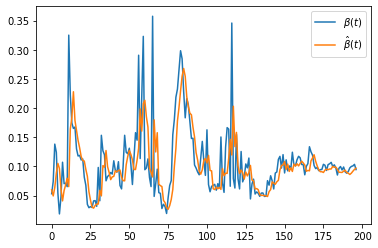

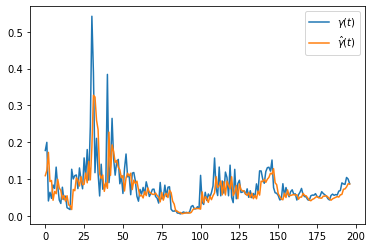

In [20]:
plt.figure(1) 
plt.plot(y_beta, label=r'$\beta(t)$') # r'$\beta คือการเขียนให้อยู่ในรูปแบบ beta ที่เราคุ้นเคย
plt.plot(beta_hat, label=r'$\hat{\beta}(t)$') # เป็น Beta ที่ prdict 
plt.legend()

plt.figure(2)
plt.plot(y_gamma, label=r'$\gamma (t)$')
plt.plot(gamma_hat, label=r'$\hat{\gamma}(t)$')
plt.legend()

In [21]:
covid_df.shape

(211, 8)

In [22]:
beta.shape

(210,)

In [23]:
########## Time-dependent SIR model ##########

##### Parameters for the Time-dependent SIR model #####
stop_X = 0 # stopping criteria

# iteration -> การวนซ้ำ ในที่นี้หมายถึงการทำให้เกิด loop
stop_day = 211 # maximum iteration days (W in the paper) คือวันที่มากที่สุดที่ข้อมูลมีอยู่ตอนนั้น ก็คือ 554 วัน 

day_count = 0
turning_point = 0

In [24]:
Susceptible_predict = [Susceptible[-1]] # กลุ่มที่ยังไม่ได้เข้ามาอยู่ในส่วนของ Infected หรือว่า Recovered (ก็คือเป็นแล้วหาย)
Infected_predict = [Infected[-1]] # เป็นแล้วยังไม่หาย หรือว่ายังไม่เสียชีวิต
Recovered_and_Death_predict = [Recovered_and_Death[-1]]

<h2>ในการจะ predict ค่า new confirm ออกมานั้น จะต้องหาค่า confirm(t) confirm(t-1) ออกมาให้ได้ก่อน จากการใช้ Infected_predict(t) + Recovered_predict(t)

In [25]:
########## Time-dependent SIR model ##########

##### Parameters for the Time-dependent SIR model #####
stop_X = 0 # stopping criteria

# iteration -> การวนซ้ำ ในที่นี้หมายถึงการทำให้เกิด loop
stop_day = 554 # maximum iteration days (W in the paper) คือวันที่มากที่สุดที่ข้อมูลมีอยู่ตอนนั้น ก็คือ 554 วัน 

day_count = 0
turning_point = 0

Susceptible_predict = [Susceptible[-1]] # กลุ่มที่ยังไม่ได้เข้ามาอยู่ในส่วนของ Infected หรือว่า Recovered (ก็คือเป็นแล้วหาย)
Infected_predict = [Infected[-1]] # เป็นแล้วยังไม่หาย หรือว่ายังไม่เสียชีวิต
Recovered_and_Death_predict = [Recovered_and_Death[-1]]

predict_beta = np.array(beta[-orders_beta:]).tolist()
predict_gamma = np.array(gamma[-orders_gamma:]).tolist()
while (Infected_predict[-1] >= stop_X) and (day_count <= stop_day):
    if predict_beta[-1] > predict_gamma[-1]:
        turning_point += 1

    next_beta = clf_beta.predict(np.asarray([predict_beta[-orders_beta:]]))[0]
    next_gamma = clf_gamma.predict(np.asarray([predict_gamma[-orders_gamma:]]))[0]

    if next_beta < 0:
        next_beta = 0
    if next_gamma < 0:
        next_gamma = 0

    predict_beta.append(next_beta)
    predict_gamma.append(next_gamma)

    next_S = ((-predict_beta[-1] * Susceptible_predict[-1] *
               Infected_predict[-1]) / populations_list[-1]) + Susceptible_predict[-1]
    next_I = ((predict_beta[-1] * Susceptible_predict[-1] * Infected_predict[-1]) /
              populations_list[-1]) - (predict_gamma[-1] * Infected_predict[-1]) + Infected_predict[-1]
    next_R = (predict_gamma[-1] * Infected_predict[-1]) + Recovered_and_Death_predict[-1]

    Susceptible_predict.append(next_S)
    Infected_predict.append(next_I)
    Recovered_and_Death_predict.append(next_R)

    day_count += 1

In [26]:
I_t = np.array(Infected_predict)+ np.array(Recovered_and_Death_predict)

In [27]:
I_t[1]-I_t[0] # tomorrow

20137.984392210958

In [28]:
I_diff = np.rint([I_t[1:]- I_t[:-1]])[0].astype('int')

In [29]:
I_diff # This var is refered to new confirmed cases

array([20138, 20028, 19472, 19347, 19211, 19008, 18917, 18844, 18775,
       18746, 18736, 18739, 18763, 18800, 18849, 18910, 18981, 19060,
       19147, 19239, 19336, 19437, 19541, 19647, 19754, 19861, 19968,
       20074, 20177, 20279, 20377, 20472, 20562, 20648, 20729, 20804,
       20873, 20936, 20993, 21043, 21086, 21121, 21149, 21170, 21182,
       21187, 21184, 21173, 21154, 21126, 21091, 21048, 20997, 20938,
       20871, 20797, 20715, 20625, 20529, 20425, 20315, 20198, 20074,
       19944, 19808, 19666, 19519, 19366, 19208, 19045, 18877, 18705,
       18529, 18348, 18164, 17976, 17785, 17591, 17395, 17195, 16994,
       16790, 16584, 16376, 16167, 15957, 15746, 15533, 15320, 15107,
       14893, 14678, 14464, 14250, 14036, 13822, 13609, 13397, 13186,
       12975, 12765, 12557, 12350, 12144, 11939, 11736, 11535, 11335,
       11137, 10941, 10747, 10554, 10364, 10176,  9989,  9805,  9623,
        9443,  9266,  9090,  8917,  8747,  8578,  8412,  8248,  8087,
        7928,  7771,

In [41]:
# I_diff[0] คือของวันที่ 8 สิงหา 2564
print(f'New Confirmed cases tomorrow: {I_diff[9]}')
print(f'New predict Confirmed cases on Tuesday 17: {I_diff[9]}')
print(f'New predict Confirmed cases on Tuesday 24: {I_diff[16]}')
print(f'New predict Confirmed cases on Tuesday 31: {I_diff[23]}')
print(f'New Confirmed cases on Tuesday 17: 20128 and error rate (ER) is {np.round(np.abs(I_diff[9]-20128)/20128*100)} % and accuracy is {(1-(np.abs(I_diff[9]-20128)/20128))*100} %')
print(f'New Confirmed cases on Tuesday 24: 17165 and error rate (ER) is {np.round(np.abs(I_diff[16]-17165)/17165*100)} % and accuracy is {(1-(np.abs(I_diff[16]-17165)/17165))*100} %')
print(f'New Confirmed cases on Tuesday 31: 14666 and error rate (ER) is {np.round(np.abs(I_diff[23]-14666)/14666*100)} % and accuracy is {(1-(np.abs(I_diff[23]-14666)/14666))*100} %')

New Confirmed cases tomorrow: 18746
New predict Confirmed cases on Tuesday 17: 18746
New predict Confirmed cases on Tuesday 24: 18981
New predict Confirmed cases on Tuesday 31: 19647
New Confirmed cases on Tuesday 17: 20128 and error rate (ER) is 7.0 % and accuracy is 93.1339427662957 %
New Confirmed cases on Tuesday 24: 17165 and error rate (ER) is 11.0 % and accuracy is 89.42033207107485 %
New Confirmed cases on Tuesday 31: 14666 and error rate (ER) is 34.0 % and accuracy is 66.03709259511797 %


In [31]:
########## Print Info ##########
print('\nConfirmed cases tomorrow:', np.rint(Susceptible_predict[1] + Recovered_and_Death_predict[1]))
print('Infected persons tomorrow:', np.rint(Infected_predict[1]))
print('Recovered + Death persons tomorrow:', np.rint(Recovered_and_Death_predict[1]))
print('New confirmed:' ,np.rint(Infected_predict[0]-Infected_predict[1])+np.rint(Recovered_and_Death_predict[1]-Recovered_and_Death_predict[0]))

print('\nEnd day:', day_count)
print('Confirmed cases on the end day:', np.rint(Infected_predict[-2] + Recovered_and_Death_predict[-2]))

print('\nTuring point:', turning_point)


Confirmed cases tomorrow: 69988826.0
Infected persons tomorrow: 216601.0
Recovered + Death persons tomorrow: 560042.0
New confirmed: 16508.0

End day: 555
Confirmed cases on the end day: 3272387.0

Turing point: 555


In [32]:
I_t = np.rint(np.array(Infected_predict) + np.array(Recovered_and_Death_predict))

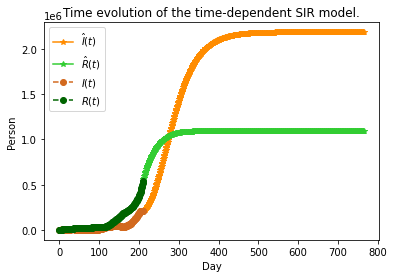

In [33]:
plt.figure(3)
plt.plot(range(len(Infected) - 1, len(Infected) - 1 + len(Infected_predict)), Infected_predict, '*-', label=r'$\hat{I}(t)$', color='darkorange')
plt.plot(range(len(Infected) - 1, len(Infected) - 1 + len(Infected_predict)), Recovered_and_Death_predict, '*-', label=r'$\hat{R}(t)$', color='limegreen')
plt.plot(range(len(Infected)), Infected, 'o--', label=r'$I(t)$', color='chocolate')
plt.plot(range(len(Infected)), Recovered_and_Death, 'o--', label=r'$R(t)$', color='darkgreen')
plt.xlabel('Day')
plt.ylabel('Person')
plt.title('Time evolution of the time-dependent SIR model.')

plt.legend()

plt.show()